In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import shapely
from shapely.geometry import mapping, Polygon, MultiPolygon
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
path = "/content/drive/My Drive/DAT_490/DATA/nyc_dac_cleaned.csv"
df = pd.read_csv(path, dtype=str)

In [4]:
# Remove unnamed columns created from misalignment or extra commas
df_cleaned = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Final shape and column list
print(f"Cleaned shape: {df_cleaned.shape}")
df_cleaned.columns.tolist()[:64]

Cleaned shape: (4918, 64)


['GEOID',
 'DAC_Designation',
 'REDC',
 'County',
 'City_Town',
 'NYC_Region',
 'Urban_Rural',
 'Tribal_Designation',
 'Household_Low_Count_Flag',
 'Population_Count',
 'Household_Count',
 'Percentile_Rank_Combined_Statewide',
 'Percentile_Rank_Combined_NYC',
 'Percentile_Rank_Combined_ROS',
 'Combined_Score',
 'Burden_Score_Percentile',
 'Vulnerability_Score_Percentile',
 'Burden_Score',
 'Vulnerability_Score',
 'Benzene_Concentration',
 'Particulate_Matter_25',
 'Traffic_Truck_Highways',
 'Traffic_Number_Vehicles',
 'Wastewater_Discharge',
 'Housing_Vacancy_Rate',
 'Industrial_Land_Use',
 'Landfills',
 'Oil_Storage',
 'Municipal_Waste_Combustors',
 'Power_Generation_Facilities',
 'RMP_Sites',
 'Remediation_Sites',
 'Scrap_Metal_Processing',
 'Agricultural_Land_Use',
 'Coastal_Flooding_Storm_Risk',
 'Days_Above_90_Degrees_2050',
 'Drive_Time_Healthcare',
 'Inland_Flooding_Risk',
 'Low_Vegetative_Cover',
 'Asian_Percent',
 'Black_African_American_Percent',
 'Redlining_Updated',
 'Latin

In [5]:
df_cleaned.isna().sum()

,0
GEOID,0
DAC_Designation,0
REDC,0
County,0
City_Town,22
...,...
Home_Energy_Affordability,137
Homes_Built_Before_1960,135
Mobile_Homes,136
Rent_Percent_Income,141


In [6]:
# Mapping county names to borough names
county_to_borough = {
    "New York": "Manhattan",
    "Bronx": "Bronx",
    "Kings": "Brooklyn",
    "Queens": "Queens",
    "Richmond": "Staten Island"
}

In [7]:
# Filter only NYC borough counties
df_nyc = df_cleaned[df_cleaned['County'].isin(county_to_borough.keys())].copy()
df_nyc['Borough'] = df_nyc['County'].map(county_to_borough)

# Group and count DAC vs Non-DAC designations
dac_summary = df_nyc.groupby(['Borough', 'DAC_Designation']).size().unstack(fill_value=0)
dac_summary['Total_Tracts'] = dac_summary.sum(axis=1)
dac_summary = dac_summary.sort_values(by='Total_Tracts', ascending=False)

In [8]:
df_nyc.iloc[:,0:9].isna().sum()

,0
GEOID,0
DAC_Designation,0
REDC,0
County,0
City_Town,0
NYC_Region,0
Urban_Rural,2
Tribal_Designation,0
Household_Low_Count_Flag,0


In [9]:
# Fill missing Urban_Rural values with 'Urban'
df_nyc['Urban_Rural'] = df_nyc['Urban_Rural'].fillna("Urban")

In [10]:
df_nyc.iloc[:,0:9].isna().sum()

,0
GEOID,0
DAC_Designation,0
REDC,0
County,0
City_Town,0
NYC_Region,0
Urban_Rural,0
Tribal_Designation,0
Household_Low_Count_Flag,0


In [11]:
# Fill missing numeric values from column 10 onward with 0
df_nyc.iloc[:, 9:] = df_nyc.iloc[:, 9:].fillna(0)

In [12]:
print("Missing values after fill:\n", df_nyc.iloc[:, 9:].isna().sum().sum())

Missing values after fill:
 0


In [13]:
# Show the result
dac_summary

DAC_Designation,Designated as DAC,Not Designated as DAC,Total_Tracts
Borough,,,
Brooklyn,308,453,761
Queens,211,458,669
Bronx,283,56,339
Manhattan,120,168,288
Staten Island,36,74,110


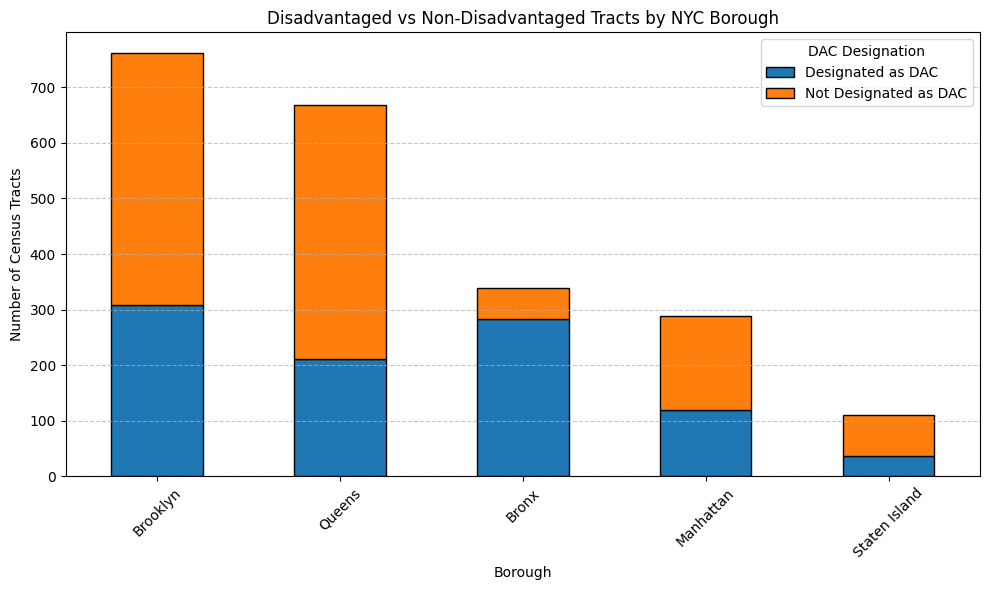

In [14]:
# Prepare DAC vs Non-DAC bar chart
dac_summary[['Designated as DAC', 'Not Designated as DAC']].plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    edgecolor='black'
)

plt.title('Disadvantaged vs Non-Disadvantaged Tracts by NYC Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Census Tracts')
plt.xticks(rotation=45)
plt.legend(title='DAC Designation')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [15]:
# Convert population and internet access columns to numeric if needed
df_nyc['Population_Count'] = pd.to_numeric(df_nyc['Population_Count'], errors='coerce')
df_nyc['Internet_Access'] = pd.to_numeric(df_nyc['Internet_Access'], errors='coerce')

# Group by DAC status and describe the statistics for each attribute
population_stats = df_nyc.groupby('DAC_Designation')['Population_Count'].describe()
internet_stats = df_nyc.groupby('DAC_Designation')['Internet_Access'].describe()

In [16]:
population_stats

,count,mean,std,min,25%,50%,75%,max
DAC_Designation,,,,,,,,
Designated as DAC,958.0,4312.869520,2290.351751,155.0,2786.25,3898.0,5436.5,28109.0
Not Designated as DAC,1209.0,3546.391232,2152.903891,0.0,2092.00,3198.0,4535.0,16594.0


In [17]:
internet_stats

,count,mean,std,min,25%,50%,75%,max
DAC_Designation,,,,,,,,
Designated as DAC,958.0,0.678422,0.246776,0.0,0.522488,0.732766,0.890027,0.998739
Not Designated as DAC,1209.0,0.401734,0.270526,0.0,0.169189,0.387978,0.607818,0.996847


In [18]:
# Set seaborn style
sns.set(style="whitegrid")

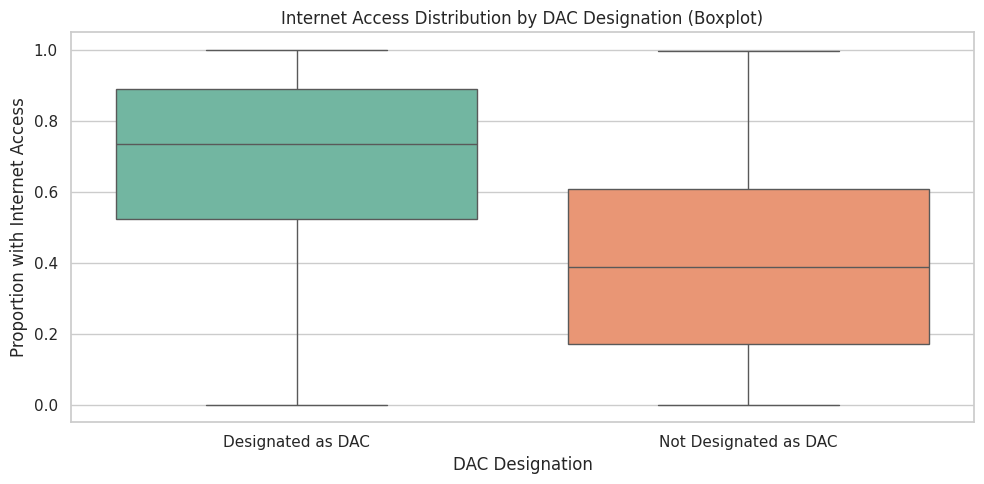

In [19]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_nyc, x='DAC_Designation', y='Internet_Access', hue='DAC_Designation', palette='Set2', legend=False)
plt.title('Internet Access Distribution by DAC Designation (Boxplot)')
plt.ylabel('Proportion with Internet Access')
plt.xlabel('DAC Designation')
plt.tight_layout()
plt.show()

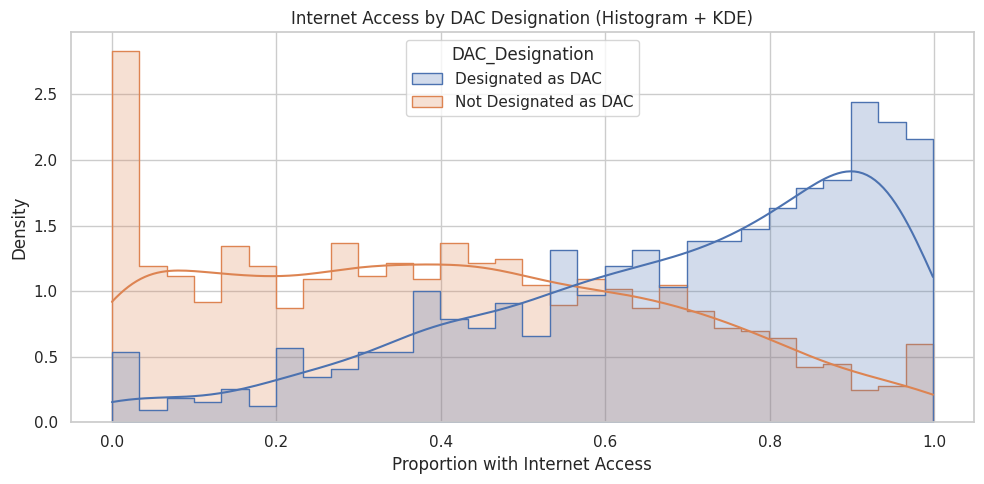

In [20]:
# KDE + Histogram plot
plt.figure(figsize=(10, 5))
sns.histplot(data=df_nyc, x='Internet_Access', hue='DAC_Designation', element='step', stat='density', common_norm=False, bins=30, kde=True)
plt.title('Internet Access by DAC Designation (Histogram + KDE)')
plt.xlabel('Proportion with Internet Access')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

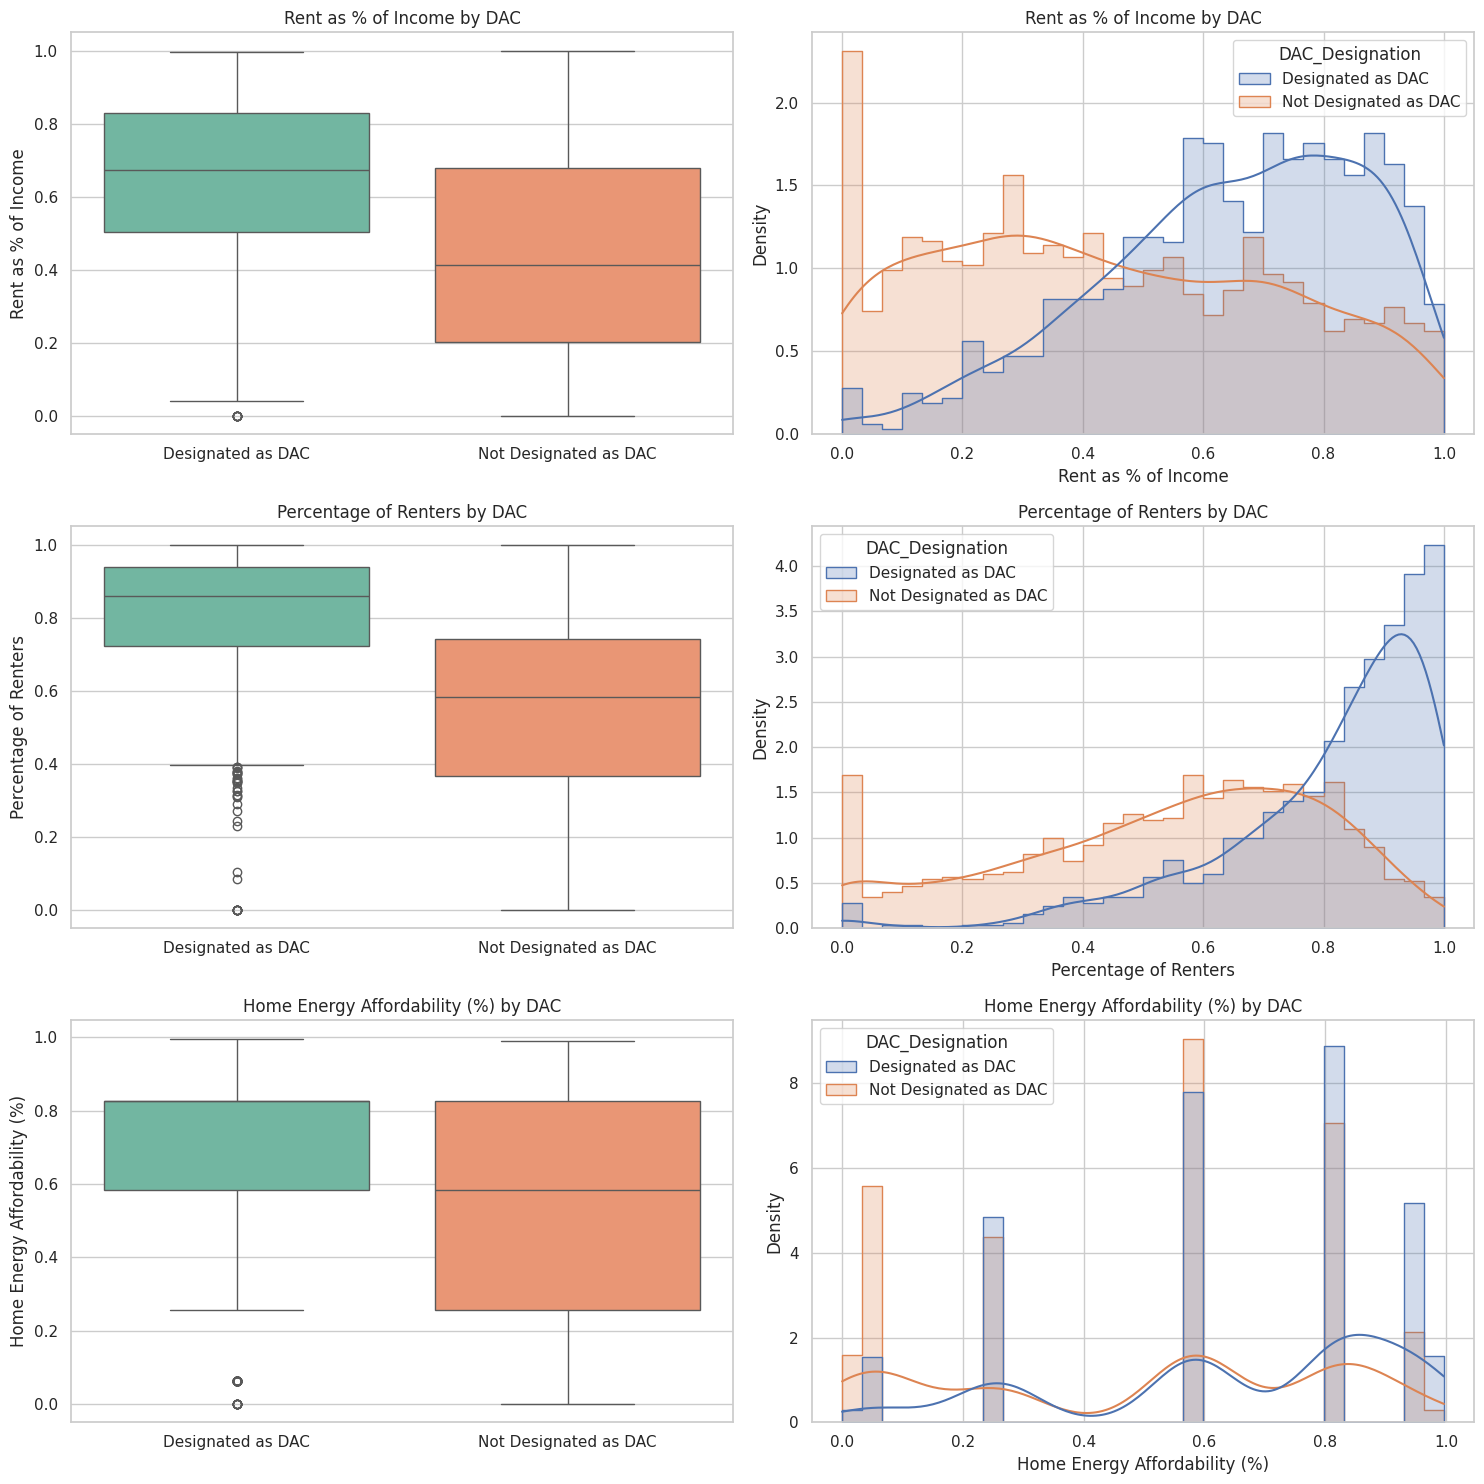

In [21]:
# Convert additional relevant fields to numeric for analysis
cols_to_convert = ['Rent_Percent_Income', 'Renter_Percent', 'Home_Energy_Affordability']
for col in cols_to_convert:
    df_nyc[col] = pd.to_numeric(df_nyc[col], errors='coerce')

# Generate boxplots and KDEs for each attribute by DAC Designation
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plot_vars = ['Rent_Percent_Income', 'Renter_Percent', 'Home_Energy_Affordability']
titles = [
    'Rent as % of Income',
    'Percentage of Renters',
    'Home Energy Affordability (%)'
]

for i, var in enumerate(plot_vars):
    # Boxplot
    sns.boxplot(data=df_nyc, x='DAC_Designation', y=var, hue='DAC_Designation', ax=axes[i, 0], palette='Set2', legend=False)
    axes[i, 0].set_title(f'{titles[i]} by DAC')
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel(titles[i])

    # KDE + Histogram
    sns.histplot(data=df_nyc, x=var, hue='DAC_Designation', element='step', stat='density', common_norm=False,
                 bins=30, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'{titles[i]} by DAC')
    axes[i, 1].set_xlabel(titles[i])
    axes[i, 1].set_ylabel('Density')

plt.tight_layout()
plt.show()

In [22]:
gdf_all = gpd.read_file("/content/drive/My Drive/DAT_490/DATA/GEO_files/tl_2020_36_tract.shp")

In [23]:
# NYC County FIPS codes for 5 boroughs
nyc_fips = ["005", "047", "061", "081", "085"]  # Bronx, Brooklyn, Manhattan, Queens, Staten Island

# Filter just NYC census tracts
gdf_tracts = gdf_all[gdf_all["COUNTYFP"].isin(nyc_fips)].copy()

In [24]:
# Make sure both have GEOID as string
df_nyc['GEOID'] = df_nyc['GEOID'].astype(str)
gdf_tracts['GEOID'] = gdf_tracts['GEOID'].astype(str)

# Merge on GEOID
gdf_merged = gdf_tracts.merge(df_nyc, on="GEOID", how="inner")

In [25]:
gdf_merged["Borough"] = gdf_merged["County"].map(county_to_borough)

In [26]:
# Separate DAC and non-DAC tracts
gdf_dac = gdf_merged[gdf_merged['DAC_Designation'] == 'Designated as DAC']
gdf_nondac = gdf_merged[gdf_merged['DAC_Designation'] != 'Designated as DAC']

In [27]:
# Set GEOID as index before filtering
# Ensure 'GEOID' is a column before setting it as index
if gdf_merged.index.name == "GEOID":
    gdf_merged = gdf_merged.reset_index()

gdf_merged = gdf_merged.set_index("GEOID")
gdf_dac = gdf_dac.set_index("GEOID")
gdf_nondac = gdf_nondac.set_index("GEOID")

In [28]:
# Create base figure
fig_pop = go.Figure()

# Population Choropleth
fig_pop.add_trace(go.Choroplethmapbox(
    geojson=json.loads(gdf_merged.to_json()),
    locations=gdf_merged.index,
    z=gdf_merged["Population_Count"],
    colorscale="YlOrRd",
    marker_opacity=0.6,
    marker_line_width=0,
    hovertext=gdf_merged["Borough"],
    hoverinfo="text",
    colorbar=dict(title="Population Count")
))


# DAC outline
dac_lon, dac_lat = [], []
for geom in gdf_dac.geometry:
    if isinstance(geom, Polygon):
        coords = list(geom.exterior.coords)
        lons, lats = zip(*coords)
        dac_lon += list(lons) + [None]
        dac_lat += list(lats) + [None]
    elif isinstance(geom, MultiPolygon):
        for poly in geom.geoms:
            coords = list(poly.exterior.coords)
            lons, lats = zip(*coords)
            dac_lon += list(lons) + [None]
            dac_lat += list(lats) + [None]

fig_pop.add_trace(go.Scattermapbox(
    mode="lines",
    lon=dac_lon,
    lat=dac_lat,
    line=dict(color="red", width=2),
    name="DAC Outline",
    hoverinfo="skip"
))

# Non-DAC outline
nondac_lon, nondac_lat = [], []
for geom in gdf_nondac.geometry:
    if isinstance(geom, Polygon):
        coords = list(geom.exterior.coords)
        lons, lats = zip(*coords)
        nondac_lon += list(lons) + [None]
        nondac_lat += list(lats) + [None]
    elif isinstance(geom, MultiPolygon):
        for poly in geom.geoms:
            coords = list(poly.exterior.coords)
            lons, lats = zip(*coords)
            nondac_lon += list(lons) + [None]
            nondac_lat += list(lats) + [None]

fig_pop.add_trace(go.Scattermapbox(
    mode="lines",
    lon=nondac_lon,
    lat=nondac_lat,
    line=dict(color="rgba(0, 0, 255, 0.4)", width=2),
    name="Non-DAC Outline",
    hoverinfo="skip"
));

In [29]:
fig_pop.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=9.5,
    mapbox_center={"lat": 40.7128, "lon": -74.0060},
    height=950,
    width=1200,
    title="NYC Census Tracts: Population (fill) with DAC Status (outlined)",
    margin={"r":0,"t":30,"l":0,"b":0},

    # Legend fix
    legend=dict(
        x=0.01,  # shift to far left
        y=0.99,
        bgcolor='white',
        bordercolor='gray',
        borderwidth=1
    )
)

fig_pop.show()

Output hidden; open in https://colab.research.google.com to view.

In [30]:
fig_no_college = go.Figure()

# Fill by Population with No College
fig_no_college.add_trace(go.Choroplethmapbox(
    geojson=json.loads(gdf_merged.to_json()),
    locations=gdf_merged.index,
    z=gdf_merged["Population_No_College"],
    colorscale="Plasma",
    marker_opacity=0.6,
    marker_line_width=0,
    hovertext=gdf_merged["Borough"],
    hoverinfo="text",
    colorbar=dict(title="Pop. No College Degree")
))

# DAC outlines
fig_no_college.add_trace(go.Scattermapbox(
    mode="lines",
    lon=dac_lon,
    lat=dac_lat,
    line=dict(color="rgba(255, 0, 0, 0.6)", width=2),
    name="DAC Outline",
    hoverinfo="skip"
))

# Non-DAC outlines
fig_no_college.add_trace(go.Scattermapbox(
    mode="lines",
    lon=nondac_lon,
    lat=nondac_lat,
    line=dict(color="rgba(0, 0, 255, 0.4)", width=2),
    name="Non-DAC Outline",
    hoverinfo="skip"
))

fig_no_college.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=9.5,
    mapbox_center={"lat": 40.7128, "lon": -74.0060},
    height=950,
    width=1200,
    title="NYC: Population with No College Degree (fill) and DAC Status (outline)",
    margin={"r":0,"t":30,"l":0,"b":0},
    legend=dict(x=0.01, y=0.99, bgcolor='white', bordercolor='gray', borderwidth=1)
)

fig_no_college.show()

Output hidden; open in https://colab.research.google.com to view.

In [31]:
fig_unemployment = go.Figure()

# Fill by Unemployment Rate
fig_unemployment.add_trace(go.Choroplethmapbox(
    geojson=json.loads(gdf_merged.to_json()),
    locations=gdf_merged.index,
    z=gdf_merged["Unemployment_Rate"],
    colorscale="Inferno",
    marker_opacity=0.6,
    marker_line_width=0,
    hovertext=gdf_merged["Borough"],
    hoverinfo="text",
    colorbar=dict(title="Unemployment Rate (%)")
))

# DAC outlines
fig_unemployment.add_trace(go.Scattermapbox(
    mode="lines",
    lon=dac_lon,
    lat=dac_lat,
    line=dict(color="rgba(255, 0, 0, 0.6)", width=2),
    name="DAC Outline",
    hoverinfo="skip"
))

# Non-DAC outlines
fig_unemployment.add_trace(go.Scattermapbox(
    mode="lines",
    lon=nondac_lon,
    lat=nondac_lat,
    line=dict(color="rgba(0, 0, 255, 0.4)", width=2),
    name="Non-DAC Outline",
    hoverinfo="skip"
))

fig_unemployment.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=9.5,
    mapbox_center={"lat": 40.7128, "lon": -74.0060},
    height=950,
    width=1200,
    title="NYC: Unemployment Rate (fill) and DAC Status (outline)",
    margin={"r":0,"t":30,"l":0,"b":0},
    legend=dict(x=0.01, y=0.99, bgcolor='white', bordercolor='gray', borderwidth=1)
)

fig_unemployment.show()

Output hidden; open in https://colab.research.google.com to view.

In [32]:
# Households with Disability Choropleth + DAC Outline Map
fig_disabled = go.Figure()

# Fill by Households_Disabled
fig_disabled.add_trace(go.Choroplethmapbox(
    geojson=json.loads(gdf_merged.to_json()),
    locations=gdf_merged.index,
    z=gdf_merged["Households_Disabled"],
    colorscale="Viridis",
    marker_opacity=0.6,
    marker_line_width=0,
    hovertext=gdf_merged["Borough"],
    hoverinfo="text",
    colorbar=dict(title="Households with Disability")
))

# DAC outlines
fig_disabled.add_trace(go.Scattermapbox(
    mode="lines",
    lon=dac_lon,
    lat=dac_lat,
    line=dict(color="rgba(255, 0, 0, 0.6)", width=2),
    name="DAC Outline",
    hoverinfo="skip"
))

# Non-DAC outlines
fig_disabled.add_trace(go.Scattermapbox(
    mode="lines",
    lon=nondac_lon,
    lat=nondac_lat,
    line=dict(color="rgba(0, 0, 255, 0.4)", width=2),
    name="Non-DAC Outline",
    hoverinfo="skip"
))

# Update layout
fig_disabled.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=9.5,
    mapbox_center={"lat": 40.7128, "lon": -74.0060},
    height=950,
    width=1200,
    title="NYC: Households with Disability (fill) and DAC Status (outline)",
    margin={"r":0,"t":30,"l":0,"b":0},
    legend=dict(x=0.01, y=0.99, bgcolor='white', bordercolor='gray', borderwidth=1)
)

fig_disabled.show()

Output hidden; open in https://colab.research.google.com to view.

In [33]:
# Map for Age_Over_65 by census tract
fig_age65 = go.Figure()

# Fill by Age_Over_65
fig_age65.add_trace(go.Choroplethmapbox(
    geojson=json.loads(gdf_merged.to_json()),
    locations=gdf_merged.index,
    z=gdf_merged["Age_Over_65"],
    colorscale="Viridis",
    marker_opacity=0.6,
    marker_line_width=0,
    hovertext=gdf_merged["Borough"],
    hoverinfo="text",
    colorbar=dict(title="Age 65+ (%)")
))

# DAC outlines
fig_age65.add_trace(go.Scattermapbox(
    mode="lines",
    lon=dac_lon,
    lat=dac_lat,
    line=dict(color="rgba(255, 0, 0, 0.6)", width=2),
    name="DAC Outline",
    hoverinfo="skip"
))

# Non-DAC outlines
fig_age65.add_trace(go.Scattermapbox(
    mode="lines",
    lon=nondac_lon,
    lat=nondac_lat,
    line=dict(color="rgba(0, 0, 255, 0.4)", width=2),
    name="Non-DAC Outline",
    hoverinfo="skip"
))

# Layout
fig_age65.update_layout(
    mapbox_style="carto-positron",
    mapbox_zoom=9.5,
    mapbox_center={"lat": 40.7128, "lon": -74.0060},
    height=950,
    width=1200,
    title="NYC: Percent of Residents Age 65+ (fill) and DAC Status (outline)",
    margin={"r":0,"t":30,"l":0,"b":0},
    legend=dict(x=0.01, y=0.99, bgcolor='white', bordercolor='gray', borderwidth=1)
)

fig_age65.show()

Output hidden; open in https://colab.research.google.com to view.

In [50]:
# First, convert all columns from column 9 onward to numeric (where possible)
for col in df_nyc.columns[9:]:
    df_nyc[col] = pd.to_numeric(df_nyc[col], errors='coerce')

columns_to_remove = [
    # Categorical / identifier columns
    'GEOID', 'DAC_Designation', 'REDC', 'County', 'City_Town', 'NYC_Region',
    'Urban_Rural', 'Tribal_Designation', 'Household_Low_Count_Flag', 'Borough',

    # Percentile and policy-specific metrics
    'Percentile_Rank_Combined_Statewide', 'Percentile_Rank_Combined_NYC',
    'Combined_Score', 'Burden_Score_Percentile', 'Vulnerability_Score_Percentile',
    'Burden_Score', 'Vulnerability_Score', 'Percentile_Rank_Combined_ROS',

    # Environmental infrastructure variables (sparse or unclear scale)
    'Oil_Storage', 'Power_Generation_Facilities', 'Remediation_Sites',
    'Scrap_Metal_Processing', 'RMP_Sites', 'Agricultural_Land_Use', 'Landfills',
    'Municipal_Waste_Combustors',

    # Optional niche variables (environmental/collinear)
    'Benzene_Concentration', 'Particulate_Matter_25', 'Traffic_Truck_Highways',
    'Wastewater_Discharge', 'Housing_Vacancy_Rate', 'Industrial_Land_Use',
    'Drive_Time_Healthcare', 'Low_Vegetative_Cover'
]

# Drop the unwanted columns from the dataframe
df_nyc_cleaned = df_nyc.drop(columns=columns_to_remove)

# Update the numeric columns to reflect the cleaned dataframe
numeric_cols = df_nyc_cleaned.select_dtypes(include='number').columns

In [51]:
# Create correlation matrix
correlation_matrix = df_nyc_cleaned[numeric_cols].corr().round(2)

# Generate Plotly heatmap
fig_corr = px.imshow(
    correlation_matrix,
    text_auto=True,
    aspect="auto",
    color_continuous_scale="RdBu_r",
    title="Correlation Heatmap of Socioeconomic Variables"
)

# Customize layout size
fig_corr.update_layout(
    height=1000,
    width=1500,
    margin=dict(l=40, r=40, t=60, b=40)
)

fig_corr.show()

In [36]:
# Filter and map Borough
df_nyc = df_nyc[df_nyc['County'].isin(county_to_borough.keys())].copy()
df_nyc['Borough'] = df_nyc['County'].map(county_to_borough)

# Group population by borough
borough_population = df_nyc.groupby("Borough")["Population_Count"].sum().reset_index()

# Format numbers with commas for labels
borough_population["Population_Label"] = borough_population["Population_Count"].apply(lambda x: f"{int(x):,}")

# Create bar chart with color per borough
pop_fig = px.bar(
    borough_population,
    x="Borough",
    y="Population_Count",
    title="Total Population by NYC Borough",
    labels={"Population_Count": "Total Population"},
    text="Population_Label",
    color="Borough"
)

pop_fig.update_traces(textposition="outside")

pop_fig.update_layout(
    height=700,
    width=1000,
    xaxis_title="Borough",
    yaxis_title="Population",
    margin=dict(l=40, r=40, t=60, b=40),
    showlegend=False
)

pop_fig.show()

In [37]:
# Filter and map Borough
df_nyc = df_nyc[df_nyc['County'].isin(county_to_borough.keys())].copy()
df_nyc['Borough'] = df_nyc['County'].map(county_to_borough)

# Group population by Borough and DAC Designation
dac_pop = df_nyc.groupby(["Borough", "DAC_Designation"])["Population_Count"].sum().reset_index()

# Format population labels with commas
dac_pop["Population_Label"] = dac_pop["Population_Count"].apply(lambda x: f"{int(x):,}")

# Create grouped bar chart (side-by-side)
dac_bar_grouped = px.bar(
    dac_pop,
    x="Borough",
    y="Population_Count",
    color="DAC_Designation",
    barmode="group",
    text="Population_Label",
    title="Population by DAC Status and Borough",
    labels={"Population_Count": "Total Population"}
)

dac_bar_grouped.update_traces(textposition="outside", marker_line_width=0.5)
dac_bar_grouped.update_layout(
    height=750,
    width=1200,
    xaxis_title="Borough",
    yaxis_title="Population",
    legend_title="DAC Status",
    margin=dict(l=40, r=40, t=60, b=40)
)

dac_bar_grouped.show()

In [38]:
# Calculate average rent burden by Borough and DAC Designation
rent_burden = df_nyc.groupby(["Borough", "DAC_Designation"])["Rent_Percent_Income"].mean().reset_index()

# Format for readable y-axis labels
rent_burden["Rent_Label"] = rent_burden["Rent_Percent_Income"].round(2).astype(str) + "%"

# Plot grouped bar chart
rent_fig = px.bar(
    rent_burden,
    x="Borough",
    y="Rent_Percent_Income",
    color="DAC_Designation",
    barmode="group",
    text="Rent_Label",
    title="Average Rent Burden (% of Income) by DAC Status and Borough",
    labels={"Rent_Percent_Income": "Rent as % of Income"}
)

rent_fig.update_traces(textposition="outside", marker_line_width=0.5)
rent_fig.update_layout(
    height=750,
    width=1200,
    xaxis_title="Borough",
    yaxis_title="Average Rent Burden (%)",
    legend_title="DAC Status",
    margin=dict(l=40, r=40, t=60, b=40)
)

rent_fig.show()

In [39]:
# Select relevant variables for clustering
cluster_vars = [
    'Unemployment_Rate', 'Internet_Access', 'Population_No_College',
    'Households_Disabled', 'Rent_Percent_Income', 'Home_Energy_Affordability',
    'Age_Over_65', 'Asthma_ED_Rate', 'COPD_ED_Rate'
]

In [40]:
X = gdf_merged[cluster_vars].apply(pd.to_numeric, errors='coerce').fillna(0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
gdf_merged['Cluster'] = kmeans.fit_predict(X_scaled)

# Create map
fig_cluster1 = px.choropleth_mapbox(
    gdf_merged,
    geojson=gdf_merged.geometry.__geo_interface__,
    locations=gdf_merged.index,
    color='Cluster',
    mapbox_style="carto-positron",
    center={"lat": 40.7128, "lon": -74.0060},
    zoom=9.5,
    opacity=0.6,
    color_continuous_scale=px.colors.qualitative.Bold,
    title="NYC Census Tract Clusters by Socioeconomic Profile (KMeans)"
)
fig_cluster1.update_layout(height=900, width=1200, margin={"r":0,"t":30,"l":0,"b":0})
fig_cluster1.show()

Output hidden; open in https://colab.research.google.com to view.

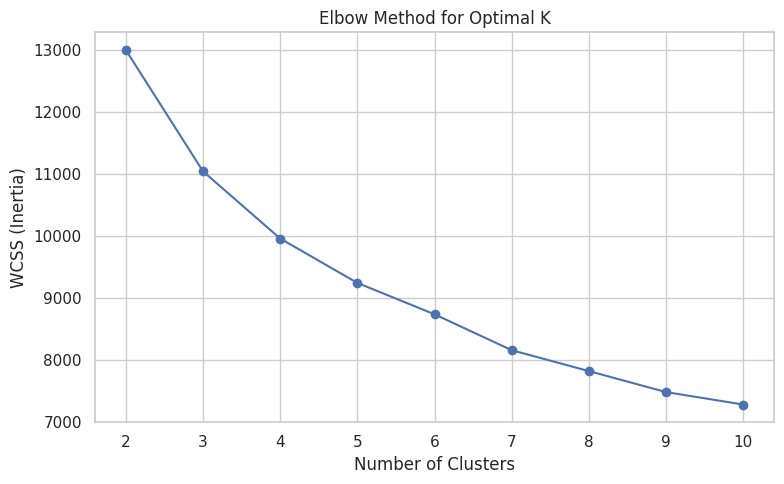

In [41]:
wcss = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Inertia)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# Define predictors
predictors = [
    'Unemployment_Rate', 'Internet_Access', 'Population_No_College',
    'Households_Disabled', 'Renter_Percent', 'Rent_Percent_Income', 'Home_Energy_Affordability',
    'Age_Over_65', 'Asthma_ED_Rate', 'COPD_ED_Rate'
]

In [43]:
df_nyc_ratios = df_nyc[df_nyc["County"].isin(county_to_borough.keys())].copy()
df_nyc_ratios["is_DAC"] = df_nyc_ratios["DAC_Designation"] == "Designated as DAC"

In [44]:
# Prepare data
df_logit = df_nyc_ratios[["is_DAC"] + predictors].dropna().copy()
df_logit[predictors] = df_logit[predictors].apply(pd.to_numeric, errors='coerce')
df_logit["is_DAC"] = df_logit["is_DAC"].astype(int)

# Fit logistic regression
formula = "is_DAC ~ " + " + ".join(predictors)
model = smf.logit(formula, data=df_logit).fit()

# Extract odds ratios and p-values
odds_ratios = pd.DataFrame({
    "Variable": model.params.index,
    "Odds_Ratio": model.params.apply(lambda x: round(np.exp(x), 4)),
    "P-Value": model.pvalues.round(4)
}).reset_index(drop=True)

Optimization terminated successfully.
         Current function value: 0.314934
         Iterations 8


In [45]:
null_model = smf.logit("is_DAC ~ 1", data=df_logit).fit(disp=0)
mcfadden_r2 = 1 - (model.llf / null_model.llf)
print(f"McFadden's R²: {round(mcfadden_r2, 4)}")

McFadden's R²: 0.5412


In [46]:
# Calculate 95% Confidence Intervals for Odds Ratios
conf = model.conf_int()
conf.columns = ["Lower", "Upper"]
conf["OR_Lower"] = np.exp(conf["Lower"])
conf["OR_Upper"] = np.exp(conf["Upper"])
conf = conf.reset_index().rename(columns={"index": "Variable"})

# Merge with odds ratios
or_table_df = odds_ratios.merge(conf[["Variable", "OR_Lower", "OR_Upper"]], on="Variable")

# Drop intercept for clarity
or_table_df = or_table_df[or_table_df["Variable"] != "Intercept"]

# Round for display
or_table_df = or_table_df.round({
    "Odds_Ratio": 2,
    "P-Value": 4,
    "OR_Lower": 2,
    "OR_Upper": 2
})

# Sort for highest odds ratio
or_table_df_sorted = or_table_df.sort_values(by="Odds_Ratio", ascending=False)

fig_or_table = go.Figure(data=[go.Table(
    header=dict(
        values=["<b>Variable</b>", "<b>Odds Ratio</b>", "<b>P-Value</b>", "<b>95% CI Lower</b>", "<b>95% CI Upper</b>"],
        fill_color="#2a3f5f",
        font=dict(color="white", size=12),
        align="left",
        height=28
    ),
    cells=dict(
        values=[
            or_table_df_sorted["Variable"],
            or_table_df_sorted["Odds_Ratio"],
            or_table_df_sorted["P-Value"],
            or_table_df_sorted["OR_Lower"],
            or_table_df_sorted["OR_Upper"]
        ],
        fill_color="lavender",
        align="left",
        height=26,
        font=dict(size=12),
        format=["", ".3f", ".4f", ".3f", ".3f"]
    ),
    columnwidth=[50, 30, 30, 30, 30]
)])

fig_or_table.update_layout(
    title="Logistic Regression: Odds Ratios Predicting DAC Designation",
    width=900,
    height=420,
    margin=dict(l=10, r=10, t=40, b=10)
)

fig_or_table.show()

In [47]:
# Run T-tests using these predictors
ttest_results = []
for col in predictors:
    dac_values = pd.to_numeric(df_nyc_ratios[df_nyc_ratios["is_DAC"]][col], errors='coerce').dropna()
    nondac_values = pd.to_numeric(df_nyc_ratios[~df_nyc_ratios["is_DAC"]][col], errors='coerce').dropna()

    t_stat, p_val = ttest_ind(dac_values, nondac_values, equal_var=False)

    ttest_results.append({
        "Variable": col,
        "Mean_DAC": round(dac_values.mean(), 4),
        "Mean_NonDAC": round(nondac_values.mean(), 4),
        "T-Statistic": round(t_stat, 4),
        "Raw_P": p_val
    })

ttest_df = pd.DataFrame(ttest_results)

# Sort by highest absolute T-statistic
ttest_df_sorted = ttest_df.reindex(ttest_df["T-Statistic"].abs().sort_values(ascending=False).index)

# Format P-values as string column
ttest_df_sorted["P-Value"] = ttest_df_sorted["Raw_P"].apply(lambda p: "< 0.001" if p < 0.001 else f"{p:.4f}")

fig_ttest_table = go.Figure(data=[go.Table(
    header=dict(
        values=["<b>Variable</b>", "<b>Mean DAC</b>", "<b>Mean Non-DAC</b>", "<b>T-Statistic</b>", "<b>P-Value</b>"],
        fill_color="#2a3f5f",
        font=dict(color="white", size=12),
        align="left",
        height=28
    ),
    cells=dict(
        values=[
            ttest_df_sorted["Variable"],
            ttest_df_sorted["Mean_DAC"],
            ttest_df_sorted["Mean_NonDAC"],
            ttest_df_sorted["T-Statistic"],
            ttest_df_sorted["P-Value"]
        ],
        fill_color="lavender",
        align="left",
        height=26,
        font=dict(size=12)
    ),
    columnwidth=[50, 30, 30, 30, 30]
)])

fig_ttest_table.update_layout(
    title="T-Test Results Based on Socioeconomic Predictors",
    width=900,
    height=420,
    margin=dict(l=10, r=10, t=40, b=10)
)

fig_ttest_table.show()